In [40]:
import json
from pathlib import Path
from mt.helper import flatten
from datetime import datetime
from dateutil.parser import parse
from typing import Any
import networkx as nx
from torch_geometric.data import Data, Batch
import requests
import re
import torch
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader

In [41]:
response = requests.get("https://raw.githubusercontent.com/tree-sitter/tree-sitter-python/master/src/node-types.json")
response

<Response [200]>

In [42]:
if (path:=Path("type_to_int.json")).exists():
    with open(path) as f:
        type_to_int = json.load(f)
else:
    types = re.findall(r'"type": "(.+)"', response.text)
    type_to_int = {t: i+1 for i, t in enumerate(list(set(types)))}
    with open("type_to_int.json", "w") as f:
        json.dump(type_to_int, f)

In [43]:
repo = Path("/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision")
repo

PosixPath('/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision')

In [44]:
commit_data_dir = repo / "commit_data"
commit_paths = list(commit_data_dir.glob("*.json"))
commit_paths.sort(key = lambda path: int(path.name.split("_")[0]))
commit_paths = {path.name.split("_")[1].removesuffix(".json"): path for path in commit_paths}
commit_paths

{'62cfcb70c38a965191fa0a1e58a49fee8bc1f9f7': PosixPath('/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision/commit_data/0_62cfcb70c38a965191fa0a1e58a49fee8bc1f9f7.json'),
 'd9b8d003d282904461d30e60b9e13ed2f74f3bc6': PosixPath('/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision/commit_data/1_d9b8d003d282904461d30e60b9e13ed2f74f3bc6.json'),
 '6452b3005905e5592ab964c5fbf5b11fe8c0687e': PosixPath('/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision/commit_data/2_6452b3005905e5592ab964c5fbf5b11fe8c0687e.json'),
 'b3e33b7ba0cc215e8ca49dc392768a7f5a6915ad': PosixPath('/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision/commit_data/3_b3e33b7ba0cc215e8ca49dc392768a7f5a6915ad.json'),
 'aaa218deaccb5ba6a14fe3b3b3623358d4da18c8': PosixPath('/home/fox/projects/general/learning-portfoli

In [45]:
def issue_open_at(issue: dict[str, Any], date: datetime) -> bool:
    created_at = parse(issue["created_at"])
    closed_at = parse(issue["closed_at"]) if issue["closed_at"] else None
    return created_at.replace(tzinfo=None) < date and (
        not closed_at or closed_at.replace(tzinfo=None) > date
    )


def number_of_issues_open(issues: dict[str, Any], date: datetime) -> int:
    return sum([1 for issue in issues if issue_open_at(issue, date)])


def number_of_stars_at(stars: list[dict[str, Any]], date: datetime) -> int:
    count = 0
    for star in stars:
        if parse(star["starred_at"]).replace(tzinfo=None) <= date:
            count += 1
    return count

In [46]:
with open(repo / "stars.json") as f:
    stars = flatten([page["items"] for page in json.load(f)])

with open(repo / "commits.json") as f:
    commits = flatten([page["items"] for page in json.load(f)])

with open(repo / "issues.json") as f:
    issues = flatten([page["items"] for page in json.load(f)])

In [8]:
def graph_to_data_object(g: nx.DiGraph) -> Data:
    ...

In [47]:
def nx_to_pyg_graph(nx_graph: nx.DiGraph) -> Data:
    node_mapping = {node: i for i, node in enumerate(nx_graph.nodes())}

    # TODO: 'ERROR' is not in type_to_int (most likely). Fix that by adding it adhoc
    x = [type_to_int.get(nx_graph.nodes[node]["type"], 0) for node in nx_graph.nodes]
    x = torch.tensor(x, dtype=torch.long).unsqueeze(1) # Shape (num_nodes, 1)

    edge_list = [[node_mapping[u], node_mapping[v]] for u, v in nx_graph.edges()]
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)

def file_features_to_graph(features: dict[str, str | bool | dict[str, int] | list[str]]) -> nx.DiGraph:
    with open(features["feature_file"]) as f:
        nx_graph = nx.node_link_graph(json.load(f)["ast"])
        return nx_to_pyg_graph(nx_graph)

In [48]:
Y = []
X = []

# graphs.append([nx.node_link_graph(file_features["ast"]) for _, file_features in commit_features.items()])

for commit in commits:
    if path:=commit_paths.get(commit["sha"]):
        commit_date = parse(commit["commit"]["author"]["date"]).replace(tzinfo=None)

        if y_scale == 0:
            y_scale = number_of_stars_at(stars, commit_date)
            y = number_of_issues_open(issues, commit_date)
            Y.append(y/y_scale)

            with open(path) as f:
                raw_data = json.load(f)
            
            
            batch = Batch.from_data_list([file_features_to_graph(file_features) for file_features in raw_data.values()])
            X.append(batch)
            print(commit["sha"], " Processed")


1fda0e850a2ff5dca7f10a2e12286c87645d6760  Processed
ec7f80be344204035f35fa09dee641d40dd767d3  Processed
3eb4333e9b069ae8ecdd6321eb7b65a531882de5  Processed
83090c2a0043fc3075bf5c16f4defa5704515ee0  Processed
ab4c10229d43e9d9f94c1e771d19c44c15461281  Processed
893b4abdc0c9df36c241c58769810f69e35dab48  Processed
127e8a703e77ccdddaf714ea82666f00b17d7743  Processed
c7e29470ce802aff0cdf89975ea56a386e6df37e  Processed
4433680aa57439ed684f9854fac3443b76e03c03  Processed
9fa5f3f072a9473fd2cf8763e85baaab294c931c  Processed
07729eb56622c8492d0c9a8565934a96605dd478  Processed
7b4681a66d5d8a532a937c04714f5beb7789f017  Processed
0e2a5ae79bc0dc8aeb1e54601888df5be01937f0  Processed
517f6d3bd9ff12a3e02f39b816edce7346bc1075  Processed
15c166ac127db5c8d1541b3485ef5730d34bb68a  Processed
a0fcd083714f9378602d635afd95810a693ded47  Processed
ef2c281a8d22ef38b80ba0edfac5bccd19fe0081  Processed
f69eee6108cd047ac8b62a2992244e9ab3c105e1  Processed
a8ebd0b3e69407e06ad4e8a4f2ade5147dda6628  Processed
668348ed6456

ZeroDivisionError: division by zero

In [10]:
pt_dir = repo / "pts"
pt_dir.mkdir(exist_ok=True)

In [ ]:
for idx, (batch, target) in enumerate(zip(X, Y)):
    torch.save((batch, target * 1000), pt_dir / f'batch_{idx}.pt')

In [12]:
class GraphDataset(Dataset):
    def __init__(self, root_dir: Path):
        self.root_dir = root_dir
        self.num_samples = len(list(root_dir.glob("*.pt")))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        batch, target = torch.load(self.root_dir / f"batch_{idx}.pt")
        return batch, target

In [13]:
# Instantiate the dataset
dataset = GraphDataset(root_dir=pt_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [14]:
for batched_data, target in dataloader:
    x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
    print(type(x), type(edge_index), type(batch), type(target))
    print(x.shape)
    print(edge_index.shape)
    break

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([344579, 1])
torch.Size([2, 344278])


In [12]:
# import torch
# from torch_geometric.data import Data, Batch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import GATConv, global_mean_pool

# class NodeFeatureEmbedding(nn.Module):
#     def __init__(self, num_embeddings, embedding_dim):
#         super(NodeFeatureEmbedding, self).__init__()
#         self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        
#     def forward(self, x):
#         # Assuming x is of shape (num_nodes, 1) where each entry is the category index
#         return self.embedding(x.squeeze())  # Embedding lookup and squeeze to drop extra dimension

# class TransformerGATModel(nn.Module):
#     def __init__(self, embedding_dim, hidden_channels, out_channels, num_heads=2):
#         super(TransformerGATModel, self).__init__()
#         self.conv1 = GATConv(embedding_dim, hidden_channels, heads=num_heads, concat=True)
#         self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        
#         transformer_encoder_layer = nn.TransformerEncoderLayer(
#             d_model=hidden_channels, nhead=num_heads, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=1)
        
#         self.attention_fc = torch.nn.Linear(hidden_channels, 1)
#         self.regressor = nn.Linear(hidden_channels, out_channels)

#     def forward(self, x, edge_index, batch):
#         x = F.relu(self.conv1(x, edge_index))
#         x = self.conv2(x, edge_index)
#         x = global_mean_pool(x, batch)
        
#         attention_scores = self.attention_fc(x).squeeze(-1)
#         attention_weights = F.softmax(attention_scores, dim=0)
        
#         x = torch.sum(x * attention_weights.unsqueeze(-1), dim=0)

#         return self.regressor(x)

In [15]:
import torch
from torch_geometric.data import Data, Batch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class NodeFeatureEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(NodeFeatureEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        
    def forward(self, x):
        # Assuming x is of shape (num_nodes, 1) where each entry is the category index
        return self.embedding(x.squeeze())  # Embedding lookup and squeeze to drop extra dimension

class TransformerGATModel(nn.Module):
    def __init__(self, embedding_dim, hidden_channels, out_channels, num_heads=2):
        super(TransformerGATModel, self).__init__()
        self.conv1 = GATConv(embedding_dim, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True)
        
        self.attention_fc = torch.nn.Linear(hidden_channels, 1)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        
        attention_scores = self.attention_fc(x).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=0)
        
        x = torch.sum(x * attention_weights.unsqueeze(-1), dim=0)

        return self.regressor(x)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
embedding_dim = 64
num_node_features = len(type_to_int)

embedding_module = NodeFeatureEmbedding(num_embeddings=num_node_features, embedding_dim=embedding_dim)
model = TransformerGATModel(embedding_dim=embedding_dim, hidden_channels=8, out_channels=1)
model.to(device)
embedding_module.to(device)

NodeFeatureEmbedding(
  (embedding): Embedding(215, 64)
)

In [18]:
optimizer = torch.optim.Adam(list(embedding_module.parameters()) + list(model.parameters()), lr=0.01)
criterion = nn.MSELoss()


model.train()
embedding_module.train()
for epoch in range(10):  # For example, 10 epochs
    total_loss = 0
    for graph_batch, target in dataloader:
        # Transfer data to the device
        x = graph_batch.x.to(device)
        edge_index = graph_batch.edge_index.to(device)
        batch = graph_batch.batch.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        
        # Embedding step
        embedded_x = embedding_module(x)
        
        # Model prediction
        prediction = model(embedded_x, edge_index, batch)
        loss = criterion(prediction, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}: Loss = {total_loss / len(dataloader)}')

Epoch 1: Loss = 149.7906237686871
Epoch 2: Loss = 72.58660560556618
Epoch 3: Loss = 48.18073551541331
Epoch 4: Loss = 51.33786765057363
Epoch 5: Loss = 47.3546475687415
Epoch 6: Loss = 36.53636870043377
Epoch 7: Loss = 54.453801547716
Epoch 8: Loss = 34.19131797362049
Epoch 9: Loss = 51.9218429515764
Epoch 10: Loss = 39.47982516931817


In [23]:
optimizer = torch.optim.Adam(list(embedding_module.parameters()) + list(model.parameters()), lr=0.000001)

model.train()
embedding_module.train()

best_loss = float('inf')  # Initialize best_loss to infinity
best_model_state = None   # To store the state of the best model

for epoch in range(50):  # For example, 10 epochs
    total_loss = 0
    for graph_batch, target in dataloader:
        # Transfer data to the device
        x = graph_batch.x.to(device)
        edge_index = graph_batch.edge_index.to(device)
        batch = graph_batch.batch.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        
        # Embedding step
        embedded_x = embedding_module(x)
        
        # Model prediction
        prediction = model(embedded_x, edge_index, batch)
        loss = criterion(prediction, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    epoch_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch+1}: Loss = {epoch_loss}')
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        # Save the model state
        best_model_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'embedding_module_state_dict': embedding_module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }
        # Example saving to file, adjust the path as necessary
        torch.save(best_model_state, 'best_weights_v1.pth')

print(f'Best Loss: {best_loss}')

Epoch 1: Loss = 9.077822717725462
Epoch 2: Loss = 9.072793016075414
Epoch 3: Loss = 9.07159415424506
Epoch 4: Loss = 9.070978760423845
Epoch 5: Loss = 9.070732068543222
Epoch 6: Loss = 9.070478627563645
Epoch 7: Loss = 9.07018323911263
Epoch 8: Loss = 9.069893411571186
Epoch 9: Loss = 9.070028480088888
Epoch 10: Loss = 9.069673685821302
Epoch 11: Loss = 9.069668635780355
Epoch 12: Loss = 9.069416875428763
Epoch 13: Loss = 9.069067512820324
Epoch 14: Loss = 9.069341558705807
Epoch 15: Loss = 9.068609900646807
Epoch 16: Loss = 9.068895588970427
Epoch 17: Loss = 9.06895994061189
Epoch 18: Loss = 9.068638254320518
Epoch 19: Loss = 9.068470352214545
Epoch 20: Loss = 9.068281576525631
Epoch 21: Loss = 9.06825328055012
Epoch 22: Loss = 9.06829082136462
Epoch 23: Loss = 9.067724509198221
Epoch 24: Loss = 9.067811851338858
Epoch 25: Loss = 9.06726178523589
Epoch 26: Loss = 9.067297416760017
Epoch 27: Loss = 9.067341878817237
Epoch 28: Loss = 9.067100194373207
Epoch 29: Loss = 9.067323788624986


In [24]:
print(f'Best Loss: {best_loss}')

Best Loss: 9.06397909239589


In [55]:
# torch.save(embedding_module.state_dict(), "embedding_weights.pth")
# torch.save(model.state_dict(), "model_weights.pth")

In [25]:
weights = torch.load("best_weights_v1.pth")
emb_weights, model_weights = weights["embedding_module_state_dict"], weights["model_state_dict"]

In [27]:
embedding_module.load_state_dict(emb_weights)
model.load_state_dict(model_weights)

<All keys matched successfully>

In [26]:
# embedding_module.load_state_dict(torch.load("embedding_weights.pth"))
# model.load_state_dict(torch.load("model_weights.pth"))

In [28]:
model.to(device)
embedding_module.to(device)

model.eval()
embedding_module.eval()

NodeFeatureEmbedding(
  (embedding): Embedding(215, 64)
)

In [29]:
from torch_geometric.explain import CaptumExplainer, Explainer, AttentionExplainer, DummyExplainer, GNNExplainer, GraphMaskExplainer


gnn_explainer = GNNExplainer().to(device)
explainer = Explainer(
    model=model,
    algorithm=gnn_explainer,
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    node_mask_type='object',
    edge_mask_type='object',
    # threshold_config=dict(
    #     threshold_type='topk',
    #     value=200,
    # ),
)

In [30]:
batched_data, target = dataset[200]

x = batched_data.x.to(device)
edge_index = batched_data.edge_index.to(device)
batch = batched_data.batch.to(device)

embedded_batched_data = embedding_module(x).detach()
explanation = explainer(embedded_batched_data, edge_index, batch=batch)
explanation

Explanation(node_mask=[542904, 1], edge_mask=[542549], prediction=[1], target=[1], x=[542904, 64], edge_index=[2, 542549], batch=[542904])

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np


In [32]:
# Graph creation
# Assuming 'edge_index', 'explanation["node_mask"]', and 'explanation["edge_mask"]' are correctly defined
G = nx.Graph()
edge_index_np = edge_index.cpu().numpy()
for source, target in edge_index_np.T:
    G.add_edge(int(source), int(target))

# Normalize node and edge importance scores for visualization
node_importance = explanation["node_mask"].cpu().numpy()
edge_importance = explanation["edge_mask"].cpu().numpy()
node_importance_normalized = node_importance / node_importance.max()
edge_importance_normalized = edge_importance / edge_importance.max()

# Define the colormap and normalization
cmap = plt.cm.viridis
norm_node = mcolors.Normalize(vmin=node_importance_normalized.min(), vmax=node_importance_normalized.max())
norm_edge = mcolors.Normalize(vmin=edge_importance_normalized.min(), vmax=edge_importance_normalized.max())

In [33]:
# Assuming edge_index and edge_importance are already defined
# Identify the top 15 edges based on importance
top_edge_indices = np.argsort(-edge_importance)[:15]
top_edges = [(edge_index_np[0][i], edge_index_np[1][i]) for i in top_edge_indices]

# Collect nodes from these top edges
nodes_from_top_edges = set()
for u, v in top_edges:
    nodes_from_top_edges.update([u, v])

# Ensure nodes from top edges are included, along with top nodes based on their importance
top_nodes_indices = np.argsort(-node_importance, axis=0)[:15].reshape(-1)
nodes_from_top_nodes = set(np.array(G.nodes)[top_nodes_indices])

# Combine nodes from top nodes and top edges
all_top_nodes = nodes_from_top_edges.union(nodes_from_top_nodes)

# Create the subgraph based on these nodes
H = G.subgraph(all_top_nodes)

In [34]:
# Print top node importance values to verify correct nodes are being selected
top_nodes_indices = np.argsort(-node_importance, axis=0)[:5].reshape(-1)
print("Top node indices:", top_nodes_indices)
print("Node importance scores for these indices:", node_importance[top_nodes_indices])

# Convert indices to actual nodes (if G.nodes() returns nodes in a consistent order with node_importance)
nodes_from_top_nodes = {list(G.nodes())[i] for i in top_nodes_indices}
print("Nodes selected based on top indices:", nodes_from_top_nodes)

# Verify these are the correct nodes by checking their importance scores
print("Importance scores of selected nodes:")
for node in nodes_from_top_nodes:
    print(f"Node {node}: {node_importance[list(G.nodes()).index(node)]}")

# Collect nodes from top edges
nodes_from_top_edges = {u for u, v in top_edges} | {v for u, v in top_edges}

# Combine nodes from top nodes and top edges
all_top_nodes = nodes_from_top_edges.union(nodes_from_top_nodes)

# Create the subgraph based on these nodes
H = G.subgraph(all_top_nodes)
print("Nodes in subgraph H:", H.nodes())
print("Edges in subgraph H:", H.edges())

Top node indices: [232353 232395 232362 232522 232525]
Node importance scores for these indices: [[0.7577831]
 [0.7416046]
 [0.7273927]
 [0.7227116]
 [0.7217053]]
Nodes selected based on top indices: {232517, 232525, 232344, 232383, 232351}
Importance scores of selected nodes:
Node 232517: [0.7227116]
Node 232525: [0.7217053]
Node 232344: [0.7577831]
Node 232383: [0.7416046]
Node 232351: [0.7273927]
Nodes in subgraph H: [232344, 232351, 232352, 232353, 232355, 232485, 232358, 232359, 232357, 232486, 232487, 232361, 232363, 232494, 232497, 232372, 232373, 232374, 232505, 232506, 232507, 232382, 232383, 232384, 232514, 232516, 232517, 232525, 232433, 232436]
Edges in subgraph H: [(232351, 232352), (232351, 232353), (232352, 232357), (232353, 232355), (232485, 232486), (232485, 232487), (232358, 232363), (232359, 232361), (232494, 232497), (232372, 232373), (232372, 232374), (232505, 232506), (232505, 232507), (232382, 232383), (232382, 232384), (232514, 232516), (232514, 232517), (232433

In [35]:
node_importance[top_nodes_indices]

array([[0.7577831],
       [0.7416046],
       [0.7273927],
       [0.7227116],
       [0.7217053]], dtype=float32)

In [36]:
edge_importance[top_edge_indices]

array([0.7273354 , 0.7104749 , 0.710453  , 0.7099835 , 0.7099221 ,
       0.7098496 , 0.70975673, 0.709575  , 0.7095465 , 0.7093872 ,
       0.70935595, 0.70923364, 0.7091083 , 0.70909935, 0.7090707 ],
      dtype=float32)

In [37]:
# Example to check the presence of directed edges
for u, v in H.edges():
    direct_match = np.where((edge_index_np[0] == u) & (edge_index_np[1] == v))[0]
    reverse_match = np.where((edge_index_np[0] == v) & (edge_index_np[1] == u))[0]

    if direct_match.size > 0:
        print(f"Direct edge ({u}, {v}) found at index {direct_match[0]}")
    elif reverse_match.size > 0:
        print(f"Reverse edge ({v}, {u}) found at index {reverse_match[0]}")
    else:
        print(f"No matching edge found for ({u}, {v}) or ({v}, {u})")

Direct edge (232351, 232352) found at index 232269
Direct edge (232351, 232353) found at index 232270
Direct edge (232352, 232357) found at index 232272
Direct edge (232353, 232355) found at index 232274
Direct edge (232485, 232486) found at index 232398
Direct edge (232485, 232487) found at index 232399
Direct edge (232358, 232363) found at index 232276
Direct edge (232359, 232361) found at index 232278
Direct edge (232494, 232497) found at index 232407
Direct edge (232372, 232373) found at index 232293
Direct edge (232372, 232374) found at index 232294
Direct edge (232505, 232506) found at index 232417
Direct edge (232505, 232507) found at index 232418
Direct edge (232382, 232383) found at index 232299
Direct edge (232382, 232384) found at index 232300
Direct edge (232514, 232516) found at index 232425
Direct edge (232514, 232517) found at index 232426
Direct edge (232433, 232436) found at index 232347


In [38]:
# Check if all nodes of the included edges are part of the subgraph
for u, v in top_edges:
    if not H.has_node(u) or not H.has_node(v):
        print(f"Missing node for edge ({u}, {v}) in subgraph H.")

for n in top_nodes_indices:
    if not H.has_node(n):
        print(f"???")

???
???
???


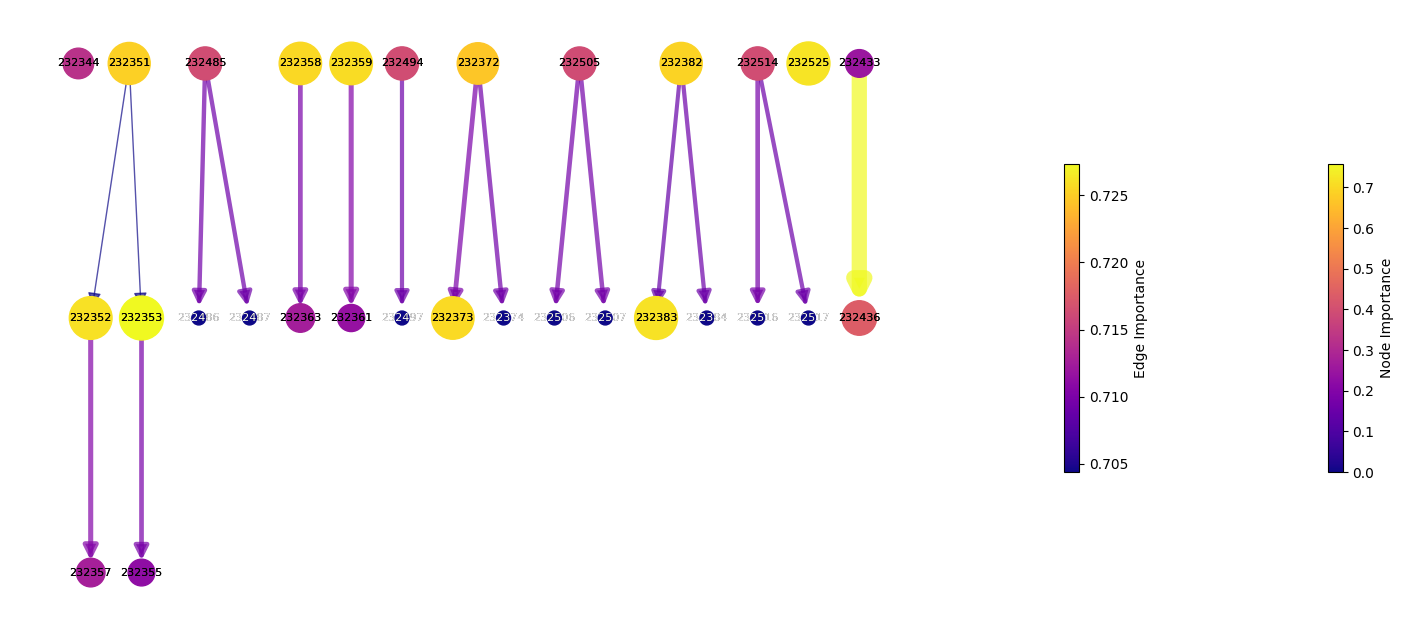

In [39]:
# Update node and edge importance arrays for visualization
node_importance_H = np.array([node_importance[node] for node in H.nodes])
edge_importance_H = np.array([edge_importance[np.where(((edge_index_np[0] == u) & (edge_index_np[1] == v)) | ((edge_index_np[0] == v) & (edge_index_np[1] == u)))[0][0]] for u, v in H.edges])

# Normalize importance
norm_node = mcolors.Normalize(vmin=node_importance_H.min(), vmax=node_importance_H.max())
norm_edge = mcolors.Normalize(vmin=edge_importance_H.min(), vmax=edge_importance_H.max())

# Set up color maps
cmap = plt.cm.plasma
cmap_edge = plt.cm.plasma

# Define colors and widths based on importance
node_colors = [cmap(norm_node(value)) for value in node_importance_H]
edge_colors = [cmap_edge(norm_edge(value)) for value in edge_importance_H]
edge_widths = [1 + 10 * norm_edge(value) for value in edge_importance_H]

# Layout and drawing
pos = nx.nx_agraph.graphviz_layout(H, prog='dot')
# pos = nx.spring_layout(H)
fig, ax = plt.subplots(figsize=(20, 8))
nx.draw_networkx_nodes(H, pos, node_size=100 + 900 * (node_importance_H / node_importance_H.max()), node_color=node_colors, ax=ax)
nx.draw_networkx_edges(H, pos, edgelist=H.edges(), width=edge_widths, edge_color=edge_colors, alpha=0.7, arrowstyle='-|>', arrowsize=20, arrows=True, ax=ax)
nx.draw_networkx_labels(H, pos, font_size=8, ax=ax)

# Node labels with contrasting colors
for node, (x, y) in pos.items():
    label_color = 'white' if np.mean(cmap(norm_node(node_importance[node]))) < 0.5 else 'black'
    plt.text(x, y, str(node), ha='center', va='center', color=label_color, fontsize=8)

plt.axis('off')

# Colorbars for node and edge importance
sm_node = plt.cm.ScalarMappable(cmap=cmap, norm=norm_node)
sm_node.set_array([])
cbar_node = plt.colorbar(sm_node, ax=ax, orientation='vertical', shrink=0.5, label='Node Importance')

sm_edge = plt.cm.ScalarMappable(cmap=cmap_edge, norm=norm_edge)
sm_edge.set_array([])
cbar_edge = plt.colorbar(sm_edge, ax=ax, orientation='vertical', shrink=0.5, label='Edge Importance', pad=0.1)

plt.show()

KeyboardInterrupt: 

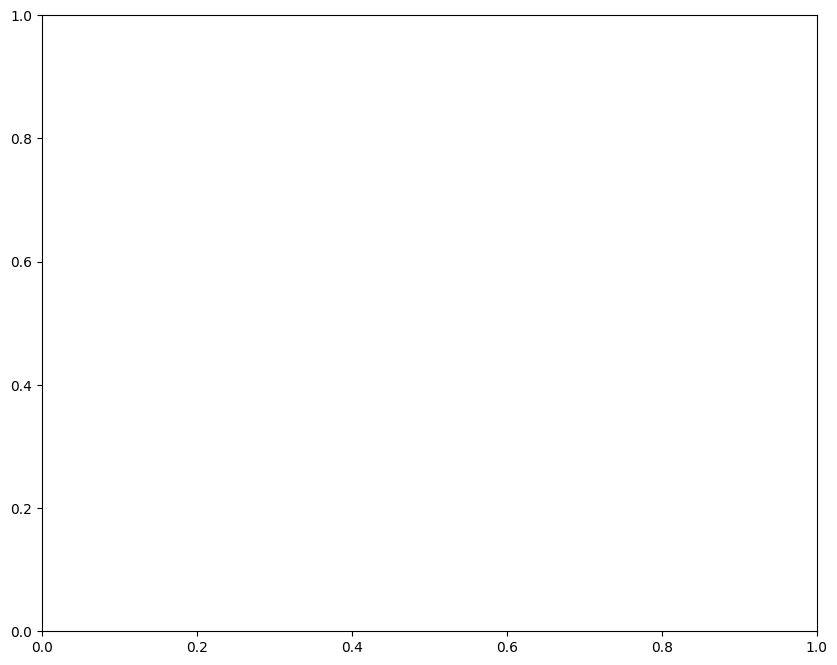

In [61]:
# Assuming 'edge_index', 'explanation["node_mask"]', and 'explanation["edge_mask"]' are correctly defined
G = nx.Graph()
edge_index_np = edge_index.cpu().numpy()
for source, target in edge_index_np.T:
    G.add_edge(int(source), int(target))

# Normalize node and edge importance scores for visualization
node_importance = explanation["node_mask"].cpu().numpy()
edge_importance = explanation["edge_mask"].cpu().numpy()
node_importance_normalized = node_importance / node_importance.max()
edge_importance_normalized = edge_importance / edge_importance.max()

# Define the colormap and normalization
cmap = plt.cm.viridis
norm_node = mcolors.Normalize(vmin=node_importance_normalized.min(), vmax=node_importance_normalized.max())
norm_edge = mcolors.Normalize(vmin=edge_importance_normalized.min(), vmax=edge_importance_normalized.max())

fig, ax = plt.subplots(figsize=(10, 8))

# Use PyGraphviz to find the tree layout
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

# Node sizes and colors based on importance
node_sizes = 100 + 900 * node_importance_normalized
node_colors = [cmap(norm_node(value)) for value in node_importance_normalized]

# Apply a power transformation to increase variation in edge widths
edge_widths = 1 + np.power(edge_importance_normalized * 2, 4)  # Adjust the exponent as needed

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)

# Draw edges with colors and widths based on their importance
edges = edge_index_np.T
edge_colors = [cmap(norm_edge(edge_importance_normalized[i])) for i in range(len(edges))]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, edge_color=edge_colors, ax=ax)

# Draw node labels with contrasting colors for readability
for node, (x, y) in pos.items():
    label_color = 'white' if np.mean(node_colors[node]) < 0.5 else 'black'
    plt.text(x, y, str(node), ha='center', va='center', color=label_color, fontsize=8)

plt.axis('off')

# Add colorbar as a legend for node and edge importance
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_node)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Importance')

plt.show()

In [65]:
import pygraphviz as pgv
from IPython.display import Image

# Create a PyGraphviz graph from the NetworkX graph
A = nx.nx_agraph.to_agraph(G)

# Apply styles to nodes and edges based on importance scores
for i, (node, imp) in enumerate(zip(G.nodes(), node_importance_normalized)):
    color = plt.cm.viridis(norm_node(imp))
    hex_color = mcolors.rgb2hex(color)
    A.get_node(node).attr['style'] = 'filled'
    A.get_node(node).attr['fillcolor'] = hex_color
    A.get_node(node).attr['width'] = str(0.1 + 0.9 * imp)  # adjust the size

for i, ((src, dst), imp) in enumerate(zip(G.edges(), edge_importance_normalized)):
    color = plt.cm.viridis(norm_edge(imp))
    hex_color = mcolors.rgb2hex(color)
    A.get_edge(src, dst).attr['color'] = hex_color
    A.get_edge(src, dst).attr['penwidth'] = str(1 + np.power(imp * 2, 4))  # adjust the width based on importance

# Set Graphviz layout options (e.g., 'dot', 'neato', 'fdp')
A.layout(prog='dot')

# Draw and display the graph (output as PNG for viewing in Jupyter)
A.draw('graph.png')
Image('graph.png')

KeyboardInterrupt: 

In [ ]:
from pyvis.network import Network
import networkx as nx

# Initialize Pyvis network
net = Network(notebook=False, height="750px", width="100%")

# Add nodes with size and color based on importance
for node in G.nodes():
    node_imp = node_importance_normalized[node]
    node_color = plt.cm.viridis(norm_node(node_imp))
    hex_color = mcolors.rgb2hex(node_color)
    net.add_node(node, title=f'Node: {node}', size=10 + 90 * node_imp, color=hex_color)

# Add edges with width and color based on importance
for src, dst in G.edges():
    edge_idx = G.edges[src, dst]['index']
    edge_imp = edge_importance_normalized[edge_idx]
    edge_color = plt.cm.viridis(norm_edge(edge_imp))
    hex_color = mcolors.rgb2hex(edge_color)
    width = 1 + np.power(edge_imp * 2, 4)  # Apply a power transformation to increase variation
    net.add_edge(src, dst, width=width, color=hex_color, title=f'Importance: {edge_imp:.2f}')

# Set the physics layout for the network
net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -80000,
      "centralGravity": 0.3,
      "springLength": 95
    },
    "minVelocity": 0.75
  }
}
""")

# Generate the network in an HTML file
net.show("graph.html")